# Create IoT Embedding

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# import JSON data

with open("raw_training_data/allEndpoints.json","r",encoding="utf-8") as json_file:
     apis = json.load(json_file)
        

In [ ]:
apis[2]

In [ ]:
print("Number of APIs: ",len(apis))
#calculate number of endpoints
endpoint_lens = [len(apis[i]["endpoints"]) for i in range(len(apis))]
print("Total number of Endpoints: ",sum(endpoint_lens))
print("AVG number of Endpoints: ", sum(endpoint_lens)/len(apis))
apis[2]

## Define Data Structures for APIs

In [ ]:
import operator


def string_to_list(value):
        s_list = list(value)
        out_list = []
        for i in range(len(s_list)):
            if operator.contains('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',s_list[i]):
                out_list.append('.')
            else:
                if s_list[i].isupper():
                    out_list.append('.')
                    out_list.append(s_list[i].lower())
                else:
                    out_list.append(s_list[i])

        out_string = "".join(out_list)
        return [x for x in out_string.split('.') if x]
    
class Api:
    def __init__(self,api_data):
        self._raw_data = api_data
        self.key = api_data["key"]
        self.name = api_data["name"]
        self.version_key = api_data["versionKey"]
        self.version_name = api_data["versionName"]
        self.endpoints = [Endpoint(api_data["endpoints"][i],i) for i in range(len(api_data["endpoints"]))]
    
    def get_property(self,name):
        return self._raw_data[name]
    
    def has_endpoints(self):
        return len(self.endpoints) != 0
    
    def __str__(self):
        json_dict = {}
        json_dict["name"] = self.name
        json_dict["key"] = self.key
        json_dict["version_name"] = self.version_name
        json_dict["version_key"] = self.version_key
        json_dict["endpoints_size"] = len(self.endpoints)
        return json.dumps(json_dict)
    
class Endpoint:
    def __init__(self,endpoint_data,endpoint_num):
        self._raw_data = endpoint_data
        self.path = endpoint_data["path"]
        self.method = endpoint_data["method"]
        self.request_parameters = [Parameter(endpoint_data["requestParameters"][i]) for i in range(len(endpoint_data["requestParameters"]))]
        self.response_parameters = [Parameter(endpoint_data["responseParameters"][i]) for i in range(len(endpoint_data["responseParameters"]))]
        self.path_list = self.path_to_list()
        self.num = endpoint_num
    
    def get_property(self,name):
        return self._raw_data[name]
    
    def has_parameters(self):
        return (len(self.request_parameters) != 0 or len(self.response_parameters) != 0)
    
    def path_to_list(self):
        return string_to_list(self.path)
    
    def __str__(self):
        json_dict = {}
        json_dict["method"] = self.method
        json_dict["path"] = self.path
        json_dict["request_parameters_size"] = len(self.request_parameters)
        json_dict["response_parameters_size"] = len(self.response_parameters)
        return json.dumps(json_dict)
    
class Parameter:
    def __init__(self,parameter_data):
        self._raw_data = parameter_data
        self.xpath = parameter_data["xpath"]
        self.name = parameter_data["name"]
        
        #if xpath is empty, overwrite it with name
        if not self.xpath:
            self.xpath = self.name
            
        self.xpath_list = self.xpath_to_list()
        self.name_list = self.name_to_list()
    
    def get_property(self,name):
        return self._raw_data[name]
    
    def name_to_list(self):
        return string_to_list(self.name)
        
    def xpath_to_list(self):
        return string_to_list(self.xpath)
    
    def __str__(self):
        json_dict = {}
        json_dict["name"] = self.name
        json_dict["xpath"] = self.xpath
        json_dict["name_list"] = self.name_list
        json_dict["xpath_list"] = self.xpath_list
        return json.dumps(json_dict)
    
    
        

## Define Data Structure for words to embed

In [ ]:
class Word:
    def __init__(self, word:str):
        self.word : str = word
        self.total_occurences :int = 0
        self.occures_as_endpoint: int = 0
        self.occures_as_request: int = 0
        self.occures_as_response: int = 0
        self.occures_in_apis = set() #APIs as integers
        self.occures_in_endpoints = set()
        self.occures_in_payload = set()
    
    def _increase_total_and_add_to_sets(self, api, endpoint, payload=None):
        '''adds an API, endpoint and payloads to the sets (if they aren't contained)'''
        self.total_occurences += 1
        self.occures_in_apis.add(api)
        self.occures_in_endpoints.add(str(api)+str(endpoint))
        if payload is not None:
            self.occures_in_payload.add(str(api)+str(endpoint)+str(payload))
    
    def add_as_endpoint(self, api, endpoint):
        self.occures_as_endpoint += 1
        self._increase_total_and_add_to_sets(api, endpoint)
        
    
    def add_as_request(self, api, endpoint, payload):
        self.occures_as_request += 1
        self._increase_total_and_add_to_sets(api, endpoint, payload)
    
    def add_as_response(self, api, endpoint, payload):
        self.occures_as_response += 1
        self._increase_total_and_add_to_sets(api, endpoint, payload)    
        
    def __str__(self):
        json_dict = {}
        json_dict["word"] = self.word
        json_dict["total_occurences"] = self.total_occurences
        json_dict["occures_as_endpoint"] = self.occures_as_endpoint
        json_dict["occures_as_request"] = self.occures_as_request
        json_dict["occures_as_response"] = self.occures_as_response
        json_dict["contained_in_apis"] = list(self.occures_in_apis)
        json_dict["contained_in_endpoints"] = list(self.occures_in_endpoints)
        json_dict["contained_in_payloads"] = list(self.occures_in_payload)
        return json.dumps(json_dict)
    

In [ ]:
word = Word("test")

word.add_as_endpoint(2, "options")
word.add_as_request(3, 5, 7)
word.add_as_response(3, 8, 1)
word.add_as_endpoint(13, 9)


print(word)

## Load Training Data:

In [ ]:
apis_list = [Api(apis[i]) for i in range(len(apis))]

In [ ]:
# Tets print some data
api = 1
endpoint = 0

#Some tests:
print(apis_list[api])
print(apis_list[api].endpoints[endpoint].path_list)
print(apis_list[api].endpoints[endpoint].response_parameters[0])

In [ ]:
# Test: print data for one api
api = 2

#Some tests:
print("API:")
print(apis_list[api])
print()
print("Endpoints:")

for endpoint in apis_list[api].endpoints:
    print("Endpoint:")
    print(endpoint)
    print()
    print("request parameters:")
    for rp in endpoint.request_parameters:
        print(rp)
    print()
    print("response parameters:")
    for rp in endpoint.response_parameters:
        print(rp)
    print()
    print()
    
    
    
    

## Determine Vocabulary

In [ ]:
#create a vocabulary dictionary
vocab_dict = {}  # dict:  key: word; value: num_occurences

def increment_vocab_dict(key_list):
    for key in key_list:
        if key in vocab_dict:
            vocab_dict[key]+=1
        else:
            vocab_dict[key] = 1
        

        
for api in apis_list:
    
    for endpoint in api.endpoints:
       
        #add path:
        increment_vocab_dict(endpoint.path_list)
        #add request parameters
        for request_parameter in endpoint.request_parameters:
            increment_vocab_dict(request_parameter.xpath_list)
                
        #add response parameters
        for response_parameter in endpoint.response_parameters:
            increment_vocab_dict(response_parameter.xpath_list)
        
                

                

In [ ]:
#sort vocabulary by occurence
sorted_vocab_dict = {k: v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1],reverse=True)}
l = list(sorted_vocab_dict.items())

print("number words: "+str(len(l)))

print("Most common words:")
print(l[:100])




# Create Word Objects

In [ ]:
# create objects for words

relevant_words = dict() # (word : WordObject)

def add_to_words(word:str, api:int, word_type:str, endpoint, payload=None):
    try:
        word_obj = None

        if word not in relevant_words:
            word_obj = Word(word)
            relevant_words[word] = word_obj
        else:
            word_obj = relevant_words[word]

        if word_type == "endpoint":
            word_obj.add_as_endpoint(api, endpoint)

        elif word_type == "request":
             word_obj.add_as_request(api, endpoint, payload)

        elif word_type == "response":
             word_obj.add_as_response(api, endpoint, payload)
                    
    except KeyError:
        print(word)

            
for api_nr, api in enumerate(apis_list):
    for endpoint_nr, endpoint in enumerate(api.endpoints):
        
        for path in endpoint.path_list:
            add_to_words(path, api_nr, "endpoint", endpoint_nr)
        
        for request_parameter in endpoint.request_parameters:
            for parameter in request_parameter.xpath_list:
                add_to_words(parameter, api_nr, "request", endpoint_nr, "req")
        
        for response_parameter in endpoint.response_parameters:
            for parameter in response_parameter.xpath_list:
                add_to_words(parameter, api_nr, "response", endpoint_nr, "res")   
    
    


## Filter Words

- just proceed with words that occur at least in 10 different APIs <br>
  --> Embedding is created based on different API designs<br>
  --> A word that occurs in many different APIs is more relevant 

In [ ]:
# filter relevant words function

def filter_words_for_api_occurence(relevant_words:dict, apis_at_least:int):
    delete_keys = []
    for key, value in relevant_words.items():
        if len(value.occures_in_apis) < apis_at_least:
            delete_keys.append(key)
    for k in delete_keys:
        del relevant_words[k]
    return relevant_words    

In [ ]:
print("number words before filtering: "+str(len(relevant_words)))

relevant_words = filter_words_for_api_occurence(relevant_words, 10)

print("number words after filtering: "+str(len(relevant_words)))

In [ ]:
word_objects_list = list(relevant_words.items())
print(word_objects_list[:5])
len(word_objects_list)

# Create Similarity Matrix

<h3>Determine Similarity between two words</h3>

Words are given as word objects, that contain the following information:

- the word itself :String
- Set of APIs that contain the word :Set
- Set of Endpoints that contain the Word. (API_Endpoint) is one element in this set :Set
- Set of Payloads that contain the Word. (API_Endpoint_Request) or (API_Endpoint_Response) is one element :Set
<br><br>


<h4>Similarity between two words</h4>

- words are similar when they occur in the same APIs/ Endpoints / Payloads
- when a word occures in many places where another doesn't occur, then they are not so similar
- if two words occur in the the same payload, then they also occur in the same endpoint
- if two words occur in the the same endpoint, then they also occur in the same API

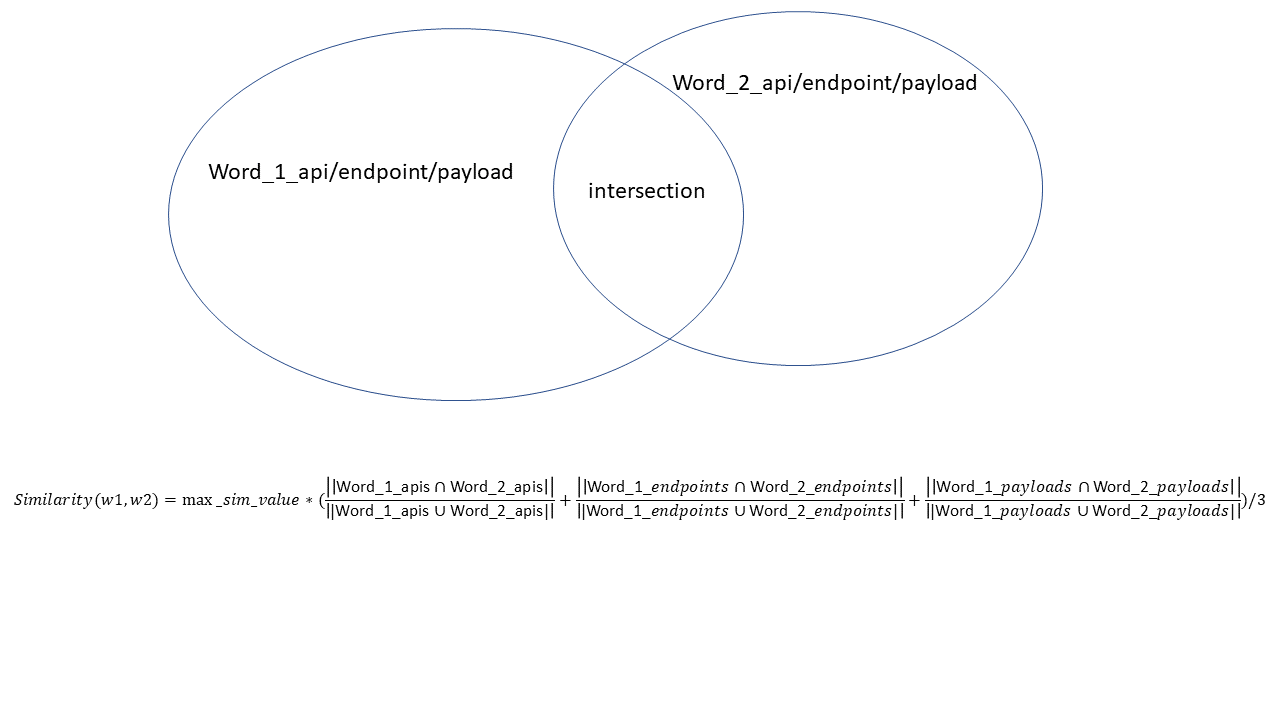


In [ ]:
# determine similarity between two words

def get_similarity(word1, word2, max_similarity_value=10):
    '''returns similarity value between two given word objects'''
    def _get_similarity_distribution_over_apis_endpoints_payloads(word1, word2):
        def _get_intersection_over_apis(word1, word2):
            size_intersection = len(word1.occures_in_apis.intersection(word2.occures_in_apis))
            size_union = len(word1.occures_in_apis.union(word2.occures_in_apis))
            return size_intersection/size_union
        
        def _get_intersection_over_endpoints(word1, word2):
            size_intersection = len(word1.occures_in_endpoints.intersection(word2.occures_in_endpoints))
            size_union = len(word1.occures_in_endpoints.union(word2.occures_in_endpoints))
            return size_intersection/size_union
        
        def _get_intersection_over_payloads(word1, word2):
            try:
                size_intersection = len(word1.occures_in_payload.intersection(word2.occures_in_payload))
                size_union = len(word1.occures_in_payload.union(word2.occures_in_payload))
                return size_intersection/size_union
            except:
                # when it has no payload because a word is just a endpoint
                return -1
            
        intersection_over_apis = _get_intersection_over_apis(word1, word2)
        intersection_over_endpoints = _get_intersection_over_endpoints(word1, word2)
        intersection_over_payloads = _get_intersection_over_payloads(word1, word2)
        
        if intersection_over_payloads > -1:
            return (intersection_over_apis + intersection_over_endpoints + intersection_over_payloads)/3
        else:
            return (intersection_over_apis + intersection_over_endpoints)/2

        
    word1 = word1[1]
    word2 = word2[1]
        
    return _get_similarity_distribution_over_apis_endpoints_payloads(word1, word2) * max_similarity_value

In [ ]:
import numpy as np

similarity_values = []

similarity_matrix = np.zeros((len(word_objects_list),len(word_objects_list)))

for j in range(len(similarity_matrix)):
    if j % 100 == 0:
        print("progress: "+str(j))
    for k in range(j):
        similarity_value = get_similarity(word_objects_list[j], word_objects_list[k])
        similarity_matrix[j][k] = similarity_value
        similarity_matrix[k][j] = similarity_value
        
        similarity_values.append(similarity_value)

In [ ]:
similarity_values = np.sort(np.array(similarity_values))

In [ ]:
plt.figure(figsize=(20,6))
plt.title("Similarity Values between Words")
plt.plot(similarity_values)
plt.xlabel('Values')
plt.ylabel('Similarity')

In [ ]:
# similarity values
plt.figure(figsize=(20,6))
plt.title("Distribution of Similarity Values between Words")
plt.hist(similarity_values, bins='auto')
plt.xlabel('similarity value')
plt.ylabel('density')
plt.show()

In [ ]:
first_index_not_zero = 0
for i, val in enumerate(similarity_values):
    if val != 0:
        first_index_not_zero = i
        break

print("number similaritv values: "+str(len(similarity_values)))
print("first index not zero: "+str(first_index_not_zero))
print("proportion not zero: "+str((len(similarity_values)-first_index_not_zero)/len(similarity_values)))

similarity_values[918977]

- Many similarity values are zero so we plot just the non zero ones

In [ ]:
# non zero similarity values
plt.figure(figsize=(20,10))
plt.title("Distribution of Non-Zero Similarity Values between Words")
plt.hist(similarity_values[first_index_not_zero:], bins='auto')
plt.xlabel('similarity value')
plt.ylabel('density')
plt.show()

- similarity values pile up at the lower end so we apply a circle function centered at 10 with radius 10 to adjust the values

In [ ]:
circle_fct = lambda v: (10**2 - (10-v)**2)**0.5

In [ ]:
# plot circle function

x = np.linspace(0,10)
y = circle_fct(x)

plt.title("Circle Function")
plt.plot(x,y)

In [ ]:
# adjust similarity values by applying circle function
def adjust_similarity(similarity_matrix, circle_fct):
    similarity_values = []

    for i in range(len(similarity_matrix)):
        for k in range(i):
            new_similarity_value = circle_fct(similarity_matrix[i][k])
            similarity_matrix[i][k] = new_similarity_value
            similarity_matrix[k][i] = new_similarity_value
            similarity_values.append(new_similarity_value)

    similarity_values = np.sort(np.array(similarity_values))
    
    return similarity_matrix, similarity_values

In [ ]:
similarity_matrix, similarity_values = adjust_similarity(similarity_matrix, circle_fct)

In [ ]:
# non zero similarity values after adjustment
plt.figure(figsize=(20,10))
plt.title("Distribution of Non-Zero Similarity Values between Words")
plt.hist(similarity_values[first_index_not_zero:], bins='auto')
plt.xlabel('similarity value')
plt.ylabel('density')
plt.show()

- similarity values still pile up at the lower end so we apply the circle function again

In [ ]:
similarity_matrix, similarity_values = adjust_similarity(similarity_matrix, circle_fct)

In [ ]:
# non zero similarity values after adjustment
plt.figure(figsize=(20,10))
plt.title("Distribution of Non-Zero Similarity Values between Words")
plt.hist(similarity_values[first_index_not_zero:], bins='auto')
plt.xlabel('similarity value')
plt.ylabel('density')
plt.show()

- now it's a centered distribution

In [ ]:
print(similarity_matrix.shape)
print(len(word_objects_list))

# Select Words to embed

Words that are embedded should have

- large number of occurence
- large standard deviation of distances to other words (some far away; some near)

In [ ]:
from statsmodels.stats.weightstats import DescrStatsW

words_stats = np.zeros((len(word_objects_list), 3))  # [[number_occurences; weighted_std(distances_to_other_words); word_obj], [], ...]

# weights for weighted std is number of occurences
weights = np.array([i[1].total_occurences for i in word_objects_list])

for i, element in enumerate(words_stats):
    element[0] = word_objects_list[i][1].total_occurences
    
    weighted_stats = DescrStatsW(similarity_matrix[i], weights, ddof=0)
    element[1] = weighted_stats.std



In [ ]:
# plot std of similarity to other words

plt.figure(figsize=(20,10))
plt.title("Distribution of Standard Deviation of Similarity Values of Words")
plt.hist(words_stats[:,1], bins='auto')
plt.xlabel('standard deviation')
plt.ylabel('density')
plt.show()

In [ ]:
# std vs number occurences
plt.figure(figsize=(20,10))
plt.title("Standard Deviation of Distances over Number Occurences of Words")
plt.plot(words_stats[:,0], words_stats[:,1], "bx")
plt.xlabel('number occurences')
plt.ylabel('std')

In [ ]:
words_over_10k = [i for i in words_stats if i[0] > 5000]

len(words_over_10k)

# Filter list for elements to embed

- determine words to embed by deviding Standard Deviation of Distances over Number Occurences of Words with a line

In [ ]:
def filter_words_stats_list(borderline_m, borderline_x0, words_stats):
    result_indexes = []
    
    for i, element in enumerate(words_stats):
        x = element[0] # occurences
        y = element[1] # std
        
        if borderline_m* x + borderline_x0 < y: # if it's above border
            result_indexes.append(i)
    return np.array(result_indexes)

def filter_list(list_to_filter, indexes_to_use):
    result = []
    for i in indexes_to_use:
        result.append(list_to_filter[i])
    try:
        return np.array(result)
    except:
        return result
    
    
indexes_to_embed = filter_words_stats_list(-0.0002,2.9, words_stats)

words_stats_to_embed = filter_list(words_stats, indexes_to_embed)


len(indexes_to_embed)


        
        
    

In [ ]:
# std vs number occurences
# red x are the words to embed
plt.figure(figsize=(20,10))
plt.title("Embedded (red) and Not Embedded (blue) words")
plt.plot(words_stats[:,0], words_stats[:,1], "bx")
plt.plot(words_stats_to_embed[:,0], words_stats_to_embed[:,1], "rx")
plt.xlabel('number occurences')
plt.ylabel('std')

In [ ]:
word_obj_to_embed = filter_list(word_objects_list, indexes_to_embed)

len(word_obj_to_embed)

In [ ]:
similarity_matrix_to_embed = np.zeros((len(word_obj_to_embed),len(word_obj_to_embed)))
similarity_values_to_embed = []

for j in range(len(similarity_matrix_to_embed)):
    if j % 100 == 0:
        print(j)
    for k in range(j):
        similarity_value = circle_fct(circle_fct(get_similarity(word_obj_to_embed[j], word_obj_to_embed[k])))
        similarity_matrix_to_embed[j][k] = similarity_value
        similarity_matrix_to_embed[k][j] = similarity_value
        
        similarity_values_to_embed.append(similarity_value)

In [ ]:
#similarity values of elements to embed
plt.figure(figsize=(20,10))
plt.title("Distribution of Similarity Values of embedded Words")
plt.hist(similarity_values_to_embed, bins='auto')
plt.xlabel('similarity value')
plt.ylabel('density')
plt.show()

# Transform Similarity Matrix into Distance Matrix

- large similarity --> small distance (and vice versa)
<br><br>
- mirror similarity value in the middle and shift it one to the right to prevent values of zero

distance(similarity) = 11-similarity_value

In [ ]:
def transform_similarity_into_distance_value(similarity_value, max_similarity_value, min_distance=1, max_diatnce=11):
    return max_diatnce+((min_distance-max_diatnce)/max_similarity_value)*similarity_value

In [ ]:
dist_matrix = np.zeros((len(word_obj_to_embed),len(word_obj_to_embed)))
distance_values = []

max_similarity_value = 10

for i in range(len(similarity_matrix_to_embed)):
    for k in range(i):
        distance_value = transform_similarity_into_distance_value(similarity_matrix_to_embed[i][k], max_similarity_value)
        dist_matrix[i][k] = distance_value
        dist_matrix[k][i] = distance_value
        
        distance_values.append(distance_value)       
        

In [ ]:
# distance values

plt.figure(figsize=(20,10))
plt.title("Distribution of Distances of embedded Words")
plt.hist(distance_values, bins='auto')
plt.xlabel('similarity value')
plt.ylabel('density')
plt.show()

- there are many distance values of 11 that are not very important and small distance values that are important

- the weight matrix states how important it is, that the final embedding has the right distance between two words

- the lower the distance between two words is the more important it is that the distance is properly contained in the final embedding

In [ ]:
max_distance_value = 11
weight_at_zero_distance = 3

weight_dist = lambda w: w*(1-weight_at_zero_distance)/max_distance_value + weight_at_zero_distance

In [ ]:
# plot weight function

x = np.linspace(0,11)
y = weight_dist(x)

plt.figure(figsize=(20,6))
plt.title("Weight(distance)")
plt.plot(x,y)

- distance 0 is 3 times more important to be contained properly than the max distance of 11

In [ ]:
# make weights(importance) for distance values
# small distances being small is more important than large distances being large

weight_matrix = np.ones((len(dist_matrix),len(dist_matrix)))

for i in range(len(weight_matrix)):
    for k in range(i):
        weight = weight_dist(dist_matrix[i][k])
        weight_matrix[i][k] = weight
        weight_matrix[k][i] = weight
        
weight_matrix

# Train Embedding

In [ ]:
import random

from scipy.optimize import minimize
from scipy.spatial import distance_matrix

def trainVectors(distMatrix, weightMatrix, dimensions: int, vec=None, log = True):
    '''
    returns trained embedding vectors
    distMatrix: matrix describing distances between vectors
    dimensions: number of dimensions of output vectors
    
    '''
    
    def initVectors(numb:int, dim:int):
        '''returns (numb):int randomly initialized vectors with (dim):int dimensions each'''
        return np.random.rand(len(distMatrix), dimensions)
    
    def transform_vectors_into_scipy_input(vectors):
        '''transforms the list of vectors into one vector that can be handled by the scypy optimize library'''
        return vectors.reshape(len(distMatrix)*dimensions)
    
    def transform_vectors_into_normal_format(vectors):
        '''transforms the vectors into a list of single vectors (one for each word)'''
        return vectors.reshape(distMatrix.shape[0], dimensions)
    
    def loss(vectors):
        '''returns the loss value based on the given vectors (both formats accepted)
           the return value must be minimized by adjusting the vectors to solve the problem
        '''        
        vectors = transform_vectors_into_normal_format(vectors)        
        return np.sum(np.multiply(np.square(np.subtract(distance_matrix(vectors, vectors), distMatrix)),weightMatrix))
    
    
    # init vectors
    if vec is None:
        vectors = initVectors(len(distMatrix),dimensions)
    else:
        vectors = vec
        
    loss_value = loss(vectors)
    if log:
        print("first loss:")
        print(str(loss_value))
    
    # try to get better init vectors
    for i in range(100):
        v_try = initVectors(len(distMatrix),dimensions)
        loss_try = loss(v_try)
        if loss_try < loss_value:
            vectors = v_try
            loss_value = loss_try
    
    if log:
        # print init values
        print("init Vectors:")
        print(str(vectors))
        print()
        print("should dist matrix:")
        print(str(distMatrix))
        print()
        current_dm = distance_matrix(vectors, vectors)
        print("is dist matrix:")
        print(str(current_dm))
        print()
        print("loss:")
        print(str(loss(vectors)))
        print("--------------------------------------------------------------")
        print()
        print()
       
    # minimize loss function by using scipy optimization library
    vectors = minimize(loss, transform_vectors_into_scipy_input(vectors)).x
    vectors = transform_vectors_into_normal_format(vectors)
    
    if log:
        #print results
        print("After Optimization")
        print("Vectors:")
        print(str(vectors))
        print()
        print("should dist matrix:")
        print(str(distMatrix))
        print()
        current_dm = distance_matrix(vectors, vectors)
        print("is dist matrix:")
        print(str(current_dm))
        print()
        print("loss:")
        print(str(loss(vectors)))
        print()
          
    return vectors, distance_matrix(vectors, vectors)    



In [ ]:
def train_Vectors_lbfgsb(distMatrix, weightMatrix, dimensions:int, vec=None, log=False):
    def initVectors(numb:int, dim:int, max_value=11):
        '''returns (numb):int randomly initialized vectors with (dim):int dimensions each'''
        return np.random.rand(numb, dim)*max_value-(max_value/2)
    
    def transform_vectors_into_one_vec(vectors):
        '''transforms the list of vectors into one vector that can be handled by the scypy optimize library'''
        return vectors.reshape(len(distMatrix)*dimensions)
    
    def transform_vectors_into_normal_format(vectors):
        '''transforms the vectors into a list of single vectors (one for each word)'''
        return vectors.reshape(distMatrix.shape[0], dimensions)
    
    def loss(vectors):
        '''returns the loss value based on the given vectors (both formats accepted)
           the return value must be minimized by adjusting the vectors to solve the problem
        '''        
        vectors = transform_vectors_into_normal_format(vectors)        
        return np.sum(np.multiply(np.square(np.subtract(np.square(distance_matrix(vectors, vectors)), np.square(distMatrix))), weightMatrix))/2
    
    def get_vector_index(n:int, d:int)->int:
        return n*dimensions+d

    def eucledian_squared(v1, v2):
        return np.sum(np.square(np.subtract(v1,v2)))
    
    def get_Derivative_Loss_fct_wrt_parameter(n,d):
        '''returns derivative of Loss Function w.r.t. element d of Vector n with the current vectors and distMatrix'''
        def dLoss_dXnd(v):
            res = 0
            for i in range(len(distMatrix)):
                if i != n:
                    res += 4*weightMatrix[n][i]*(v[n][d] - v[i][d])*(eucledian_squared(v[n], v[i])-distMatrix[i][n]**2)
            return res
        return dLoss_dXnd
    
    def get_gradient_function():
        rs_fct = []
        for n in range(len(distMatrix)):
            for d in range(dimensions):
                rs_fct.append(get_Derivative_Loss_fct_wrt_parameter(n,d))

        def get_gradient_vector(vectors):
            v = transform_vectors_into_normal_format(vectors)
            gradient = np.zeros(len(rs_fct))

            for i, fct in enumerate(rs_fct):
                gradient[i] = fct(v)
            return gradient
        return get_gradient_vector
    
    def relocate_vectors_to_center(vectors):
        vectors = transform_vectors_into_normal_format(vectors)
        center = []
        for i in range(len(vectors[0])):
            center.append(np.sum(vectors[:,i]))
        center = np.array(center)/len(vectors)
        vectors -= center
        return vectors
    
    if vec is None:
        vec = initVectors(len(distMatrix), dimensions)
        

    get_jac = get_gradient_function()

    if log is True:
        print("init loss = "+str(loss(vec)))
        
    vec = transform_vectors_into_one_vec(vec)
        
    vec = minimize(fun=loss, x0=vec, method='L-BFGS-B', jac=get_jac)
    
    if log is True:
        print("Optimization result:")
        print(vec)
    
    vec = vec.x
    
    if log is True:
        print("final loss = "+str(loss(vec)))
        
    return relocate_vectors_to_center(vec)

In [ ]:
dist_matrix.shape

In [ ]:
embedding_vectors = train_Vectors_lbfgsb(dist_matrix, weight_matrix, dimensions= 10, vec=None, log=True)

In [ ]:
embedding_vectors, is_distance_matrix = trainVectors(dist_matrix, weight_matrix, dimensions= 10, vec=embedding_vectors, log=True)

In [ ]:
embedding_vectors

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)

embedding_vectors


In [ ]:
# embedded words list

embedded_words = []
for i in word_obj_to_embed:
    embedded_words.append(i[0])
    
embedded_words


In [ ]:
# build embedding_dict

word_embedding_dict = {}

for i in range(len(word_obj_to_embed)):
    word_embedding_dict[word_obj_to_embed[i][0]] = embedding_vectors[i]

word_embedding_dict  

## Write Embedding into a Json File

In [ ]:
def save_embedding_to_file(filepath:str, embedding:dict):
    def convert_np_arrays_to_list_in_dict(emb_dict: dict):
        for key, value in emb_dict.items():
            emb_dict[key] = value.tolist()
        return emb_dict
    
    embedding = convert_np_arrays_to_list_in_dict(embedding)
    
    with open(filepath+".json", 'w') as file:
        json.dump(embedding, file)
    file.close()  


In [ ]:
save_embedding_to_file("open_api_embedding_5d_314_words", word_embedding_dict)